In [6]:
import requests
import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats                              #for ploting best-fit line for stock price
from statistics import mean, median
import math
import time
import datetime
import glob
import os
from collections import defaultdict
plt.style.use('ggplot')
font = {'family' : 'SimSun',
        'weight' : 'bold',
        'size'  : '12'}
plt.rc('font', **font) # pass in the font dict as kwargs
plt.rc('axes',unicode_minus=False)
plt.style.use('ggplot')

In [ ]:
# Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP 
# (or up to a total of 48,000 requests a day).

In [11]:
print(f"====Today is : {datetime.datetime.now()}====")
#Numbers = [1610]
#Numbers = [1,2,3,4,5,8,10,11,12,14,16,17,19,23,27,31,38,69,78,83,101,102,116,119,136,148,149,151,152,165,167,168,173,175,177,178,182,189,241,242,270,282,286,288,291,354,358,371,382,384,386,388,438,460,468,474,476,480,486,489,493,522,535,538,580,586,592,598,622,630,631,636,639,658,659,665,667,669,670,672,682,683,686,688,694,696,700,709,710,728,753,762,763,775,780,810,813,826,860,868,880,881,883,895,900,902,906,914,916,921,934,939,941,956,960,975,981,992,998,]
#Numbers = [i for i in range(1,3001)]
readNumbers = pd.read_excel('CAS_list20190927_c_xls.xls')
Numbers = [i for i in readNumbers['股份編號']]

====Today is : 2021-01-13 20:49:02.363938====


In [12]:
def XY_period(df, work_days, end_date):
    end_index = df['Date'].loc[(df['Date']<=end_date)].index[-1]
    start_index = end_index - work_days         # - 21 Work days
    x = df['Date'].iloc[start_index:end_index+1]                   #AxisX = Date
    y = df['Close'].iloc[start_index:end_index+1]          #AxisY = Stock Price
    return x, y

def bestfit(input_X, input_Y):
    input_X = np.arange(0,len(input_X))
    slope, intercept, r_value, p_value, std_err = stats.linregress(input_X, input_Y)
    #print(slope, intercept, r_value, p_value, std_err)
    return slope, intercept, r_value, p_value, std_err

def simple_ma(df, rolling_days=20) -> 'dataframe':
    try:
        df = df.rolling(window=rolling_days).mean()
    except: print("func simple_ma df.rolling error")
    y = df['Close'].iloc[:]#.iloc[start_index:end_index+1]          #AxisY = Stock Price
    return y

def text_result(x, y, sma_y) -> 'str' :
    try:
        if len(y[-7:])== len(sma_y[-7:]): 
            print("lengths are equal.")
    except: print("lengths error.")
    result = False
    Bottom_to_Up = False
    Up_to_Bottom = False
    temp_x = x[-7:]
    temp_y = y[-7:]
    temp_sma_y = sma_y[-7:]
    for i in range(1,len(y[-7:])):
        idx1 = round(temp_y.iloc[i-1]-temp_sma_y.iloc[i-1],4)
        idx2 = round(temp_y.iloc[i]-temp_sma_y.iloc[i],4)
        if idx2 > 0:
            if idx1 < 0:
                result = True
                Bottom_to_Up = True # y crossed sma from bottom to up.
                return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom  # (idx1 +ve & idx2 -ve)
            elif idx1 == 0:
                result = True
                Bottom_to_Up = True # y crossed sma from bottom to up.
                return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom # (idx1, idx2 == 0)
            else: pass # (idx1 +ve & idx2 +ve)
        elif idx2 == 0:
            result = True
            Up_to_Bottom = True # y crossed sma from up to bottom.
            return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom
        else:
            if idx1 > 0:
                result = True
                Up_to_Bottom = True # y crossed sma from up to bottom.
                return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom # (idx1 +ve & idx2 -ve)
            elif idx1 == 0: 
                result = True
                Up_to_Bottom = True # y crossed sma from up to bottom.
                return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom # (idx1, idx2 == 0)
            else: pass  # (idx1 -ve & idx2 -ve)
    return result, _, _, _, _, _

def text_alert(y, sma_y) -> 'Boolean':
    result = False
    increment = 0.001
    y, sma_y = y.iloc[-1], sma_y.iloc[-1]
    try:
        if y>=0.01 and y<0.25:
            increment = 0.001
        elif y>=0.25 and y<0.5:
            increment = 0.005
        elif y>=0.5 and y<10:
            increment = 0.01
        elif y>=10  and y<20:
            increment = 0.02
        elif y>=20  and y<100:
            increment = 0.05
        elif y>=100 and y<200:
            increment = 0.1
        elif y>=200 and y<500:
            increment = 0.2
        elif y>=500 and y<1000:
            increment = 0.5
        elif y>=1000 and y<2000:
            increment = 1
        elif y>=2000 and y<5000:
            increment = 2
        elif y>=5000 and y<9995:
            increment = 5
        else:
            raise Exception()
    except: print("Entered Value error.")
    if y < sma_y: # 1 - 1.05
        y += increment*10  # 1.1 - 1.05
        if y > sma_y: 
            result=True
            return result
        else: pass
    elif  y == sma_y:
        return True
    else: # 1 - 0.95
        y -= increment*10 # 0.9 - 0.95
        if y < sma_y: 
            result=True
            return result
        else: pass
    return result

#========================指明股份合計須申報淡倉===================================
def glob_path():
    paths = sorted(glob.glob("./Stock_指明股份合計須申報淡倉/*.csv"),reverse=False)
    return paths

def give_path(glob_path):
    return os.path.abspath(glob_path)

def return_df(stockCode, iteration):
    df_total = pd.DataFrame([],columns=['Date', 'Stock Code', 'Stock Name', 'Aggregated Reportable Short Positions (Shares)', 
                                        'Aggregated Reportable Short Positions (HK$)'])
    for i in glob_path()[-iteration:]:
        try:
            df = pd.read_csv(i)
            df = df[df['Stock Code']==stockCode]
            if len(df) == 0:
                raise Exception
            else:
                #print(give_path(i))
                df_total = pd.concat([df_total, df], ignore_index=True)
        except Exception as e:
            print('no this stock code: ', os.path.basename(i))
            pass
    return df_total
#========================指明股份合計須申報淡倉(END)==============================

#========================總股份資料===================================
def read_totalShares(stockNo) -> 'int: total_issued_shares':
    stockNo = "{:05d}".format(stockNo)
    path_name = "C:\\Users\\user\\Prepwork\\Stock scrape\\Stock study graph\\StockData\\"+f"StockData_{stockNo}.csv"
    df = pd.read_csv(path_name)
    total_shares = int(df['Data'].iloc[8].replace(',',''))
    return total_shares
#========================總股份資料(END)==============================

def main(start, end, end_date:str, end_date2:str):
    stock_list = pd.read_excel('CAS_list20190927_c_xls.xls')
    lastSevenList = defaultdict()
    earlyAlert = defaultdict()

    for Number in Numbers:
        try:
            Stock_name = stock_list['股票名稱'].loc[stock_list['股份編號']==Number].values[0]
            Stock_no = "{:04d}.HK".format(Number)
            Stock_name = Stock_no+"_"+Stock_name
            print(Stock_no)
            df = data.DataReader(Stock_no,'yahoo',start,end)
            df = df.reset_index()
            shortPosition_df = return_df(Number, 1)
            total_shares = read_totalShares(Number)

            #end_date = "2021-1-13"
            #end_date2 = "2020-12-25"
            x = df['Date'].iloc[:]                   #AxisX = Date
            y = df['Close'].iloc[:]          #AxisY = Stock Price
            sma20_y = simple_ma(df, 20)
            sma65_y = simple_ma(df, 65)
            crossed_result, crossed_result_date, y_value, sma_y_value, Bottom_to_Up, Up_to_Bottom = text_result(x,y,sma65_y)
            alert = text_alert(y, sma65_y)

            x30, y30 = XY_period(df, 21, end_date)
            #print(f'startdate:{x30.iloc[0]}, enddate:{x30.iloc[-1]},x30:-{x30.shape}, y30:-{y30.shape}')
            x60, y60 = XY_period(df, 42, end_date)
            #print(f'startdate:{x60.iloc[0]}, enddate:{x60.iloc[-1]},x60:-{x60.shape}, y60:-{y60.shape}')
            x90, y90 = XY_period(df, 63, end_date)
            #print(f'startdate:{x90.iloc[0]}, enddate:{x90.iloc[-1]},x90:-{x90.shape}, y90:-{y90.shape}')
            x2_30, y2_30 = XY_period(df, 21, end_date2)
            print(f'startdate2:{x2_30.iloc[0]}, enddate2:{x2_30.iloc[-1]}')
            x2_60, y2_60 = XY_period(df, 42, end_date2)
            x2_90, y2_90 = XY_period(df, 63, end_date2)

            slope30, intercept30, r_value30, p_value30, std_err30 = bestfit(x30, y30)
            slope60, intercept60, r_value60, p_value60, std_err60 = bestfit(x60, y60)
            slope90, intercept90, r_value90, p_value90, std_err90 = bestfit(x90, y90)
            slope2_30, intercept2_30, r_value2_30, p_value2_30, std_err2_30 = bestfit(x2_30, y2_30)
            slope2_60, intercept2_60, r_value2_60, p_value2_60, std_err2_60 = bestfit(x2_60, y2_60)
            slope2_90, intercept2_90, r_value2_90, p_value2_90, std_err2_90 = bestfit(x2_90, y2_90)

            x_fit30 = np.arange(0, len(x30))
            x_fit60 = np.arange(0, len(x60))
            x_fit90 = np.arange(0, len(x90))
            gap30 = max(max(y30)-mean(y30), min(y30)-mean(y30))*0.95
            gap60 = max(max(y60)-mean(y60), min(y60)-mean(y60))*0.95
            gap90 = max(max(y90)-mean(y90), min(y90)-mean(y90))*0.95
            x2_fit30 = np.arange(0, len(x2_30))
            x2_fit60 = np.arange(0, len(x2_60))
            x2_fit90 = np.arange(0, len(x2_90))
            gap2_30 = max(max(y2_30)-mean(y2_30), min(y2_30)-mean(y2_30))*0.95
            gap2_60 = max(max(y2_60)-mean(y2_60), min(y2_60)-mean(y2_60))*0.95
            gap2_90 = max(max(y2_90)-mean(y2_90), min(y2_90)-mean(y2_90))*0.95

            fig, ((ax,ax1), (ax2,ax3),(ax4,ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(14,10))
            ax.plot(x90, y90, "v-", label='stock price')
            ax.plot(x90, (intercept30 + (slope30*x_fit90)/3)+gap30, c=np.random.rand(3,), alpha=0.2)#, label='upper bf line')
            ax.plot(x90, (intercept30 + (slope30*x_fit90)/3), 'r', label='bf line 30')
            ax.plot(x90, (intercept30 + (slope30*x_fit90)/3)-gap30, c=np.random.rand(3,), alpha=0.2)#, label='lower bf line')
            ax.plot(x90, (intercept60 + (slope60*x_fit90)/2)+gap60, c=np.random.rand(3,), alpha=0.2)#, label='upper bf line')
            ax.plot(x90, (intercept60 + (slope60*x_fit90)/2), 'b', label='bf line 60')
            ax.plot(x90, (intercept60 + (slope60*x_fit90)/2)-gap60, c=np.random.rand(3,), alpha=0.2)#, label='lower bf line')
            ax.plot(x90, (intercept90 + slope90*x_fit90)+gap90, c=np.random.rand(3,), alpha=0.4)#, label='upper bf line')
            ax.plot(x90, (intercept90 + slope90*x_fit90), 'g', label='bf line 90')
            ax.plot(x90, (intercept90 + slope90*x_fit90)-gap90, c=np.random.rand(3,), alpha=0.4)#, label='lower bf line')

            ax2.plot(x2_90, y2_90, "v-", label='stock price')
            ax2.plot(x2_90, (intercept2_30 + (slope2_30*x2_fit90)/3)+gap2_30, c=np.random.rand(3,), alpha=0.2)#, label='upper bf line')
            ax2.plot(x2_90, (intercept2_30 + (slope2_30*x2_fit90)/3), 'r', label='bf line 30')
            ax2.plot(x2_90, (intercept2_30 + (slope2_30*x2_fit90)/3)-gap2_30, c=np.random.rand(3,), alpha=0.2)#, label='lower bf line')
            ax2.plot(x2_90, (intercept2_60 + (slope2_60*x2_fit90)/2)+gap2_60, c=np.random.rand(3,), alpha=0.2)#, label='upper bf line')
            ax2.plot(x2_90, (intercept2_60 + (slope2_60*x2_fit90)/2), 'b', label='bf line 60')
            ax2.plot(x2_90, (intercept2_60 + (slope2_60*x2_fit90)/2)-gap2_60, c=np.random.rand(3,), alpha=0.2)#, label='lower bf line')
            ax2.plot(x2_90, (intercept2_90 + slope2_90*x2_fit90)+gap2_90, c=np.random.rand(3,), alpha=0.4)#, label='upper bf line')
            ax2.plot(x2_90, (intercept2_90 + slope2_90*x2_fit90), 'g', label='bf line 90')
            ax2.plot(x2_90, (intercept2_90 + slope2_90*x2_fit90)-gap2_90, c=np.random.rand(3,), alpha=0.4)#, label='lower bf line')

            ax4.plot(x[-240:],y[-240:],'black')
            ax4.plot(x[-240:],sma20_y[-240:],'red', label='sma_20')
            ax4.plot(x[-240:],sma65_y[-240:],'blue', label='sma_65')

            ax1 = plt.subplot(1,2,2) #nrow=1, ncol=2, plot_number=2
            left, width = 0, 1
            bottom, height = 0, 1
            right = left + width
            top = bottom + height
            output_text = ''

            if crossed_result == True:
                if Bottom_to_Up == True:
                    output_text = f'Last 7 days has crossed: {crossed_result}\n& crossed on: {crossed_result_date}\ny:{y_value}\nsma_y:{sma_y_value}\n\n趨勢由低向上: {Bottom_to_Up}'
                    text_content = f'{Stock_name}_{Stock_no}'
                    lastSevenList[text_content] = {'StockNo':Number, 'Bottom_to_Up':Bottom_to_Up}
                elif Up_to_Bottom == True:
                    output_text = f'Last 7 days has crossed: {crossed_result}\n& crossed on: {crossed_result_date}\ny:{y_value}\nsma_y:{sma_y_value}\n\n趨勢由上至下: {Up_to_Bottom}'
                    text_content = f'{Stock_name}_{Stock_no}'
                    lastSevenList[text_content] = {'StockNo':Number, 'Up_to_Bottom':Up_to_Bottom}
            else: 
                output_text = f'Last 7 days has crossed: {crossed_result}'
            ax1.text(left, bottom+1, output_text, horizontalalignment='left', verticalalignment='top',
                    transform=ax1.transAxes,
                    fontsize=20)
            
            if alert == True:
                text_content = f'{Stock_name}_{Stock_no}'
                earlyAlert[text_content] = Number
            sp_shares = int(shortPosition_df['Aggregated Reportable Short Positions (Shares)'].iloc[-1])
            sp_dollars = shortPosition_df['Aggregated Reportable Short Positions (HK$)'].iloc[-1]
            ARSP_TIS_ratio = round(sp_shares/total_shares*100,2)
            alert_text = f"Last stock price close to sma: {alert}\nAggregatedReportableShortPositions(Shares):{str(sp_shares)}\nAggregatedReportableShortPositions(HK$): {sp_dollars}\nTotal_Issued_Shares: {str(total_shares)}\n淡倉佔總發行股份(ARSP/TIS): {str(ARSP_TIS_ratio)}%"
            ax1.text(left, bottom+0.5, alert_text, horizontalalignment='left', verticalalignment='top',
                    transform=ax1.transAxes,
                    fontsize=18)

            now = datetime.datetime.today()
            time_record = "{:02d}_{:02d}_{:02d}_".format(now.year, now.month, now.day)
            ax.set_title(f'{time_record}_{Stock_name}_{x30.iloc[-1].year}-{x30.iloc[-1].month}-{x30.iloc[-1].day}')
            ax.legend()
            ax4.legend()
            #plt.show()
            plt.tight_layout()
            fig.savefig(f'Stock study graph/Graphs/{time_record}{Number}_{crossed_result}_{alert}')
            time.sleep(1)
        except:
            Stock_no = "{:05d}".format(Number)
            Stock_no = "HKEX/"+Stock_no
            print(Stock_no)
            print("Something went wrong")
            pass
        return lastSevenList, earlyAlert

1610.HK
lengths are equal.
startdate2:2020-12-04 00:00:00, enddate2:2021-01-06 00:00:00


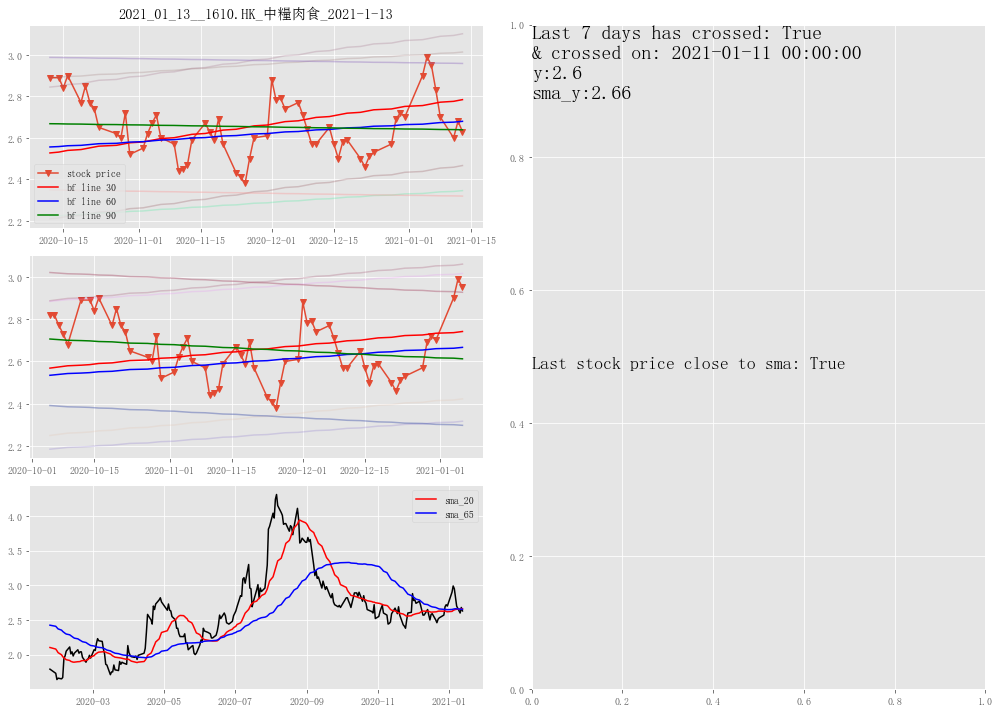

In [13]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()
nowadays = datetime.datetime.now()
sevenDaysBefore = datetime.datetime.now()-datetime.timedelta(days=7)
end_date = "{}-{}-{}".format(nowadays.year, nowadays.month, nowadays.day)
end_date2 = "{}-{}-{}".format(sevenDaysBefore.year, sevenDaysBefore.month, sevenDaysBefore.day)

lastSevenList, earlyAlert = main(start, end, end_date, end_date2)

In [14]:
print(lastSevenList)

AttributeError: 'function' object has no attribute 'lastSevenList'

In [ ]:
print(earlyAlert)

In [34]:
#df = pd.read_excel('CAS_list20190927_c_xls.xls')
#df

In [35]:
#[i for i in df['股份編號']]

In [ ]:
datetime.datetime(2021,1,13)-datetime.timedelta(days=30)

In [30]:
def XY_period(df, work_days, end_date):
    end_index = df['Date'].loc[(df['Date']<=end_date)].index[-1]
    start_index = end_index - work_days         # - 21 Work days
    x = df['Date'].iloc[start_index:end_index+1]                   #AxisX = Date
    y = df['Close'].iloc[start_index:end_index+1]          #AxisY = Stock Price
    return x, y

def bestfit(input_X, input_Y):
    input_X = np.arange(0,len(input_X))
    slope, intercept, r_value, p_value, std_err = stats.linregress(input_X, input_Y)
    #print(slope, intercept, r_value, p_value, std_err)
    return slope, intercept, r_value, p_value, std_err

def simple_ma(df, rolling_days=20) -> 'dataframe':
    try:
        df = df.rolling(window=rolling_days).mean()
    except: print("func simple_ma df.rolling error")
    y = df['Close'].iloc[:]#.iloc[start_index:end_index+1]          #AxisY = Stock Price
    return y

def text_result(x, y, sma_y) -> 'str' :
    try:
        if len(y[-7:])== len(sma_y[-7:]): 
            print("lengths are equal.")
    except: print("lengths error.")
    result = False
    Bottom_to_Up = False
    Up_to_Bottom = False
    temp_x = x[-7:]
    temp_y = y[-7:]
    temp_sma_y = sma_y[-7:]
    for i in range(1,len(y[-7:])):
        idx1 = round(temp_y.iloc[i-1]-temp_sma_y.iloc[i-1],4)
        idx2 = round(temp_y.iloc[i]-temp_sma_y.iloc[i],4)
        if idx2 > 0:
            if idx1 < 0:
                result = True
                Bottom_to_Up = True # y crossed sma from bottom to up.
                return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom  # (idx1 +ve & idx2 -ve)
            elif idx1 == 0:
                result = True
                Bottom_to_Up = True # y crossed sma from bottom to up.
                return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom # (idx1, idx2 == 0)
            else: pass # (idx1 +ve & idx2 +ve)
        elif idx2 == 0:
            result = True
            Up_to_Bottom = True # y crossed sma from up to bottom.
            return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom
        else:
            if idx1 > 0:
                result = True
                Up_to_Bottom = True # y crossed sma from up to bottom.
                return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom # (idx1 +ve & idx2 -ve)
            elif idx1 == 0: 
                result = True
                Up_to_Bottom = True # y crossed sma from up to bottom.
                return result, temp_x.iloc[i], round(temp_y.iloc[i],2), round(temp_sma_y.iloc[i],2), Bottom_to_Up, Up_to_Bottom # (idx1, idx2 == 0)
            else: pass  # (idx1 -ve & idx2 -ve)
    return result, _, _, _, _, _

def text_alert(y, sma_y) -> 'Boolean':
    result = False
    increment = 0.001
    y, sma_y = y.iloc[-1], sma_y.iloc[-1]
    try:
        if y>=0.01 and y<0.25:
            increment = 0.001
        elif y>=0.25 and y<0.5:
            increment = 0.005
        elif y>=0.5 and y<10:
            increment = 0.01
        elif y>=10  and y<20:
            increment = 0.02
        elif y>=20  and y<100:
            increment = 0.05
        elif y>=100 and y<200:
            increment = 0.1
        elif y>=200 and y<500:
            increment = 0.2
        elif y>=500 and y<1000:
            increment = 0.5
        elif y>=1000 and y<2000:
            increment = 1
        elif y>=2000 and y<5000:
            increment = 2
        elif y>=5000 and y<9995:
            increment = 5
        else:
            raise Exception()
    except: print("Entered Value error.")
    if y < sma_y: # 1 - 1.05
        y += increment*10  # 1.1 - 1.05
        if y > sma_y: 
            result=True
            return result
        else: pass
    elif  y == sma_y:
        return True
    else: # 1 - 0.95
        y -= increment*10 # 0.9 - 0.95
        if y < sma_y: 
            result=True
            return result
        else: pass
    return result

#========================指明股份合計須申報淡倉===================================
def glob_path():
    paths = sorted(glob.glob("./Stock_指明股份合計須申報淡倉/*.csv"),reverse=False)
    return paths

def give_path(glob_path):
    return os.path.abspath(glob_path)

def return_df(stockCode, iteration):
    df_total = pd.DataFrame([],columns=['Date', 'Stock Code', 'Stock Name', 'Aggregated Reportable Short Positions (Shares)', 
                                        'Aggregated Reportable Short Positions (HK$)'])
    for i in glob_path()[-iteration:]:
        try:
            df = pd.read_csv(i)
            df = df[df['Stock Code']==stockCode]
            if len(df) == 0:
                raise Exception
            else:
                #print(give_path(i))
                df_total = pd.concat([df_total, df], ignore_index=True)
        except Exception as e:
            print('no this stock code: ', os.path.basename(i))
            pass
    return df_total
#========================指明股份合計須申報淡倉(END)==============================

#========================總股份資料===================================
def read_totalShares(stockNo) -> 'int: total_issued_shares':
    stockNo = "{:05d}".format(stockNo)
    path_name = "C:\\Users\\user\\Prepwork\\Stock scrape\\Stock study graph\\StockData\\"+f"StockData_{stockNo}.csv"
    df = pd.read_csv(path_name)
    total_shares = int(df['Data'].iloc[8].replace(',',''))
    return total_shares
#========================總股份資料(END)==============================

def main(start, end, end_date:str, end_date2:str):
    stock_list = pd.read_excel('CAS_list20190927_c_xls.xls')
    lastSevenList = defaultdict()
    earlyAlert = defaultdict()

    for Number in Numbers:
        try:
            Stock_name = stock_list['股票名稱'].loc[stock_list['股份編號']==Number].values[0]
            Stock_no = "{:04d}.HK".format(Number)
            Stock_name = Stock_no+"_"+Stock_name
            print(Stock_no)
            df = data.DataReader(Stock_no,'yahoo',start,end)
            df = df.reset_index()
            shortPosition_df = return_df(Number, 1)
            total_shares = read_totalShares(Number)

            #end_date = "2021-1-13"
            #end_date2 = "2020-12-25"
            x = df['Date'].iloc[:]                   #AxisX = Date
            y = df['Close'].iloc[:]          #AxisY = Stock Price
            sma20_y = simple_ma(df, 20)
            sma65_y = simple_ma(df, 65)
            crossed_result, crossed_result_date, y_value, sma_y_value, Bottom_to_Up, Up_to_Bottom = text_result(x,y,sma65_y)
            alert = text_alert(y, sma65_y)

            x30, y30 = XY_period(df, 21, end_date)
            #print(f'startdate:{x30.iloc[0]}, enddate:{x30.iloc[-1]},x30:-{x30.shape}, y30:-{y30.shape}')
            x60, y60 = XY_period(df, 42, end_date)
            #print(f'startdate:{x60.iloc[0]}, enddate:{x60.iloc[-1]},x60:-{x60.shape}, y60:-{y60.shape}')
            x90, y90 = XY_period(df, 63, end_date)
            #print(f'startdate:{x90.iloc[0]}, enddate:{x90.iloc[-1]},x90:-{x90.shape}, y90:-{y90.shape}')
            x2_30, y2_30 = XY_period(df, 21, end_date2)
            print(f'startdate2:{x2_30.iloc[0]}, enddate2:{x2_30.iloc[-1]}')
            x2_60, y2_60 = XY_period(df, 42, end_date2)
            x2_90, y2_90 = XY_period(df, 63, end_date2)

            slope30, intercept30, r_value30, p_value30, std_err30 = bestfit(x30, y30)
            slope60, intercept60, r_value60, p_value60, std_err60 = bestfit(x60, y60)
            slope90, intercept90, r_value90, p_value90, std_err90 = bestfit(x90, y90)
            slope2_30, intercept2_30, r_value2_30, p_value2_30, std_err2_30 = bestfit(x2_30, y2_30)
            slope2_60, intercept2_60, r_value2_60, p_value2_60, std_err2_60 = bestfit(x2_60, y2_60)
            slope2_90, intercept2_90, r_value2_90, p_value2_90, std_err2_90 = bestfit(x2_90, y2_90)

            x_fit30 = np.arange(0, len(x30))
            x_fit60 = np.arange(0, len(x60))
            x_fit90 = np.arange(0, len(x90))
            gap30 = max(max(y30)-mean(y30), min(y30)-mean(y30))*0.95
            gap60 = max(max(y60)-mean(y60), min(y60)-mean(y60))*0.95
            gap90 = max(max(y90)-mean(y90), min(y90)-mean(y90))*0.95
            x2_fit30 = np.arange(0, len(x2_30))
            x2_fit60 = np.arange(0, len(x2_60))
            x2_fit90 = np.arange(0, len(x2_90))
            gap2_30 = max(max(y2_30)-mean(y2_30), min(y2_30)-mean(y2_30))*0.95
            gap2_60 = max(max(y2_60)-mean(y2_60), min(y2_60)-mean(y2_60))*0.95
            gap2_90 = max(max(y2_90)-mean(y2_90), min(y2_90)-mean(y2_90))*0.95

            fig, ((ax,ax1), (ax2,ax3),(ax4,ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(14,10))
            ax.plot(x90, y90, "v-", label='stock price')
            ax.plot(x90, (intercept30 + (slope30*x_fit90)/3)+gap30, c=np.random.rand(3,), alpha=0.2)#, label='upper bf line')
            ax.plot(x90, (intercept30 + (slope30*x_fit90)/3), 'r', label='bf line 30')
            ax.plot(x90, (intercept30 + (slope30*x_fit90)/3)-gap30, c=np.random.rand(3,), alpha=0.2)#, label='lower bf line')
            ax.plot(x90, (intercept60 + (slope60*x_fit90)/2)+gap60, c=np.random.rand(3,), alpha=0.2)#, label='upper bf line')
            ax.plot(x90, (intercept60 + (slope60*x_fit90)/2), 'b', label='bf line 60')
            ax.plot(x90, (intercept60 + (slope60*x_fit90)/2)-gap60, c=np.random.rand(3,), alpha=0.2)#, label='lower bf line')
            ax.plot(x90, (intercept90 + slope90*x_fit90)+gap90, c=np.random.rand(3,), alpha=0.4)#, label='upper bf line')
            ax.plot(x90, (intercept90 + slope90*x_fit90), 'g', label='bf line 90')
            ax.plot(x90, (intercept90 + slope90*x_fit90)-gap90, c=np.random.rand(3,), alpha=0.4)#, label='lower bf line')

            ax2.plot(x2_90, y2_90, "v-", label='stock price')
            ax2.plot(x2_90, (intercept2_30 + (slope2_30*x2_fit90)/3)+gap2_30, c=np.random.rand(3,), alpha=0.2)#, label='upper bf line')
            ax2.plot(x2_90, (intercept2_30 + (slope2_30*x2_fit90)/3), 'r', label='bf line 30')
            ax2.plot(x2_90, (intercept2_30 + (slope2_30*x2_fit90)/3)-gap2_30, c=np.random.rand(3,), alpha=0.2)#, label='lower bf line')
            ax2.plot(x2_90, (intercept2_60 + (slope2_60*x2_fit90)/2)+gap2_60, c=np.random.rand(3,), alpha=0.2)#, label='upper bf line')
            ax2.plot(x2_90, (intercept2_60 + (slope2_60*x2_fit90)/2), 'b', label='bf line 60')
            ax2.plot(x2_90, (intercept2_60 + (slope2_60*x2_fit90)/2)-gap2_60, c=np.random.rand(3,), alpha=0.2)#, label='lower bf line')
            ax2.plot(x2_90, (intercept2_90 + slope2_90*x2_fit90)+gap2_90, c=np.random.rand(3,), alpha=0.4)#, label='upper bf line')
            ax2.plot(x2_90, (intercept2_90 + slope2_90*x2_fit90), 'g', label='bf line 90')
            ax2.plot(x2_90, (intercept2_90 + slope2_90*x2_fit90)-gap2_90, c=np.random.rand(3,), alpha=0.4)#, label='lower bf line')

            ax4.plot(x[-240:],y[-240:],'black')
            ax4.plot(x[-240:],sma20_y[-240:],'red', label='sma_20')
            ax4.plot(x[-240:],sma65_y[-240:],'blue', label='sma_65')

            ax1 = plt.subplot(1,2,2) #nrow=1, ncol=2, plot_number=2
            left, width = 0, 1
            bottom, height = 0, 1
            right = left + width
            top = bottom + height
            output_text = ''

            if crossed_result == True:
                if Bottom_to_Up == True:
                    output_text = f'Last 7 days has crossed: {crossed_result}\n& crossed on: {crossed_result_date}\ny:{y_value}\nsma_y:{sma_y_value}\n\n趨勢由低向上: {Bottom_to_Up}'
                    text_content = f'{Stock_name}_{Stock_no}'
                    lastSevenList[text_content] = {'StockNo':Number, 'Bottom_to_Up':Bottom_to_Up}
                elif Up_to_Bottom == True:
                    output_text = f'Last 7 days has crossed: {crossed_result}\n& crossed on: {crossed_result_date}\ny:{y_value}\nsma_y:{sma_y_value}\n\n趨勢由上至下: {Up_to_Bottom}'
                    text_content = f'{Stock_name}_{Stock_no}'
                    lastSevenList[text_content] = {'StockNo':Number, 'Up_to_Bottom':Up_to_Bottom}
            else: 
                output_text = f'Last 7 days has crossed: {crossed_result}'
            ax1.text(left, bottom+1, output_text, horizontalalignment='left', verticalalignment='top',
                    transform=ax1.transAxes,
                    fontsize=20)
            
            if alert == True:
                text_content = f'{Stock_name}_{Stock_no}'
                earlyAlert[text_content] = Number
            sp_shares = int(shortPosition_df['Aggregated Reportable Short Positions (Shares)'].iloc[-1])
            sp_dollars = shortPosition_df['Aggregated Reportable Short Positions (HK$)'].iloc[-1]
            ARSP_TIS_ratio = round(sp_shares/total_shares*100,2)
            alert_text = f"Last stock price close to sma: {alert}\nAggregatedReportableShortPositions(Shares):{str(sp_shares)}\nAggregatedReportableShortPositions(HK$): {sp_dollars}\nTotal_Issued_Shares: {str(total_shares)}\n淡倉佔總發行股份(ARSP/TIS): {str(ARSP_TIS_ratio)}%"
            ax1.text(left, bottom+0.5, alert_text, horizontalalignment='left', verticalalignment='top',
                    transform=ax1.transAxes,
                    fontsize=18)

            now = datetime.datetime.today()
            time_record = "{:02d}_{:02d}_{:02d}_".format(now.year, now.month, now.day)
            ax.set_title(f'{time_record}_{Stock_name}_{x30.iloc[-1].year}-{x30.iloc[-1].month}-{x30.iloc[-1].day}')
            ax.legend()
            ax4.legend()
            #plt.show()
            plt.tight_layout()
            fig.savefig(f'Stock study graph/Graphs/{time_record}{Number}_{crossed_result}_{alert}')
            time.sleep(1)
        except:
            Stock_no = "{:05d}".format(Number)
            Stock_no = "HKEX/"+Stock_no
            print(Stock_no)
            print("Something went wrong")
            pass
        return lastSevenList, earlyAlert

1610.HK
lengths are equal.
startdate2:2020-12-07 00:00:00, enddate2:2021-01-07 00:00:00


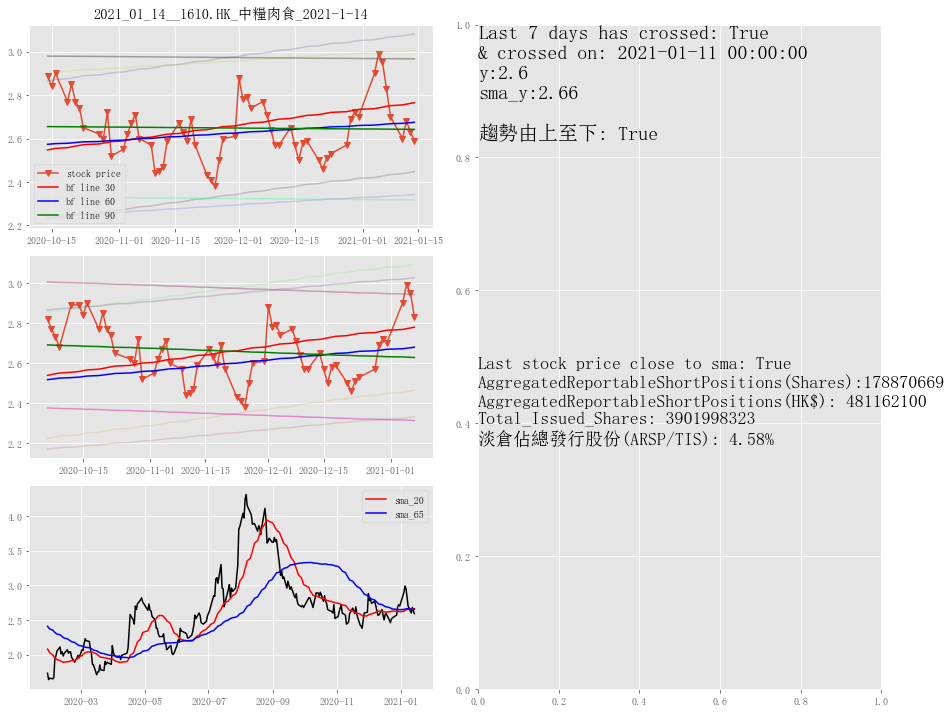

In [31]:
Numbers = [1610]

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()
nowadays = datetime.datetime.now()
sevenDaysBefore = datetime.datetime.now()-datetime.timedelta(days=7)
end_date = "{}-{}-{}".format(nowadays.year, nowadays.month, nowadays.day)
end_date2 = "{}-{}-{}".format(sevenDaysBefore.year, sevenDaysBefore.month, sevenDaysBefore.day)

lastSevenList, earlyAlert = main(start, end, end_date, end_date2)

In [43]:
print([i for i in lastSevenList.values() if lastSevenList['1610.HK_中糧肉食_1610.HK']['Up_to_Bottom']])

[{'StockNo': 1610, 'Up_to_Bottom': True}]


In [37]:
lastSevenList['1610.HK_中糧肉食_1610.HK']['Up_to_Bottom']

True

In [33]:
print(earlyAlert)

defaultdict(None, {'1610.HK_中糧肉食_1610.HK': 1610})


In [ ]:
#start = datetime.datetime(2010, 1, 1)
##end = datetime.datetime(2021, 1, 13)
#end = datetime.datetime.now()
#df = data.DataReader('.HK','yahoo',start,end)
#df.reset_index(inplace=True)

In [ ]:
#df.tail(60)